In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

DATA_PROCESSED = Path("../data/processed")
gse_id = "GSE2034"

# Load pre-computed distance matrix
print("Loading distance matrix ...")
dist_matrix = pd.read_parquet(DATA_PROCESSED / f"{gse_id}_distance_matrix.parquet")
print(dist_matrix.shape)

dist_vector = squareform(dist_matrix.values, checks=False)
Z = linkage(dist_vector, method="ward")

k_reference = 10
baseline_labels = fcluster(Z, k_reference, criterion="maxclust")


Loading distance matrix ...
(7291, 7291)


In [2]:
def bootstrap_cluster_labels(distance_matrix, k, n_boot=30, sample_frac=0.75, random_state=42):
    """Generate bootstrap clusterings by resampling genes."""
    rng = np.random.default_rng(random_state)
    labels_per_boot = []

    for b in range(n_boot):
        sample_idx = rng.choice(
            distance_matrix.shape[0],
            size=int(sample_frac * distance_matrix.shape[0]),
            replace=True,
        )
        sampled = distance_matrix.values[np.ix_(sample_idx, sample_idx)]
        dist_vec = squareform(sampled, checks=False)
        Z_boot = linkage(dist_vec, method="ward")
        labels_boot = fcluster(Z_boot, k, criterion="maxclust")
        labels_per_boot.append((sample_idx, labels_boot))

    return labels_per_boot


In [ ]:
from sklearn.metrics import adjusted_rand_score

def compute_stability_scores(baseline_labels, boot_results):
    """Compute Adjusted Rand Index (ARI) for each bootstrap run."""
    ari_scores = []

    for sample_idx, boot_labels in boot_results:
        # Map bootstrap indices to their labels
        boot_map = {idx: label for idx, label in zip(sample_idx, boot_labels)}
        
        # Find common genes (those that appear in bootstrap sample)
        common_indices = [idx for idx in range(len(baseline_labels)) if idx in boot_map]
        
        if len(common_indices) < 2:
            continue
            
        # Get labels for common genes
        baseline_subset = baseline_labels[common_indices]
        boot_subset = np.array([boot_map[idx] for idx in common_indices])
        
        # ARI accounts for label permutation - perfect for comparing clusterings
        ari = adjusted_rand_score(baseline_subset, boot_subset)
        ari_scores.append(ari)

    return np.array(ari_scores)


In [ ]:
def clusterwise_stability(baseline_labels, boot_results, k):
    """Compute per-cluster stability: what fraction of genes stay in same cluster."""
    scores = {cid: [] for cid in range(1, k + 1)}

    for sample_idx, boot_labels in boot_results:
        boot_map = {idx: label for idx, label in zip(sample_idx, boot_labels)}
        
        for cid in range(1, k + 1):
            # Genes in baseline cluster cid
            baseline_cluster_genes = {idx for idx, lbl in enumerate(baseline_labels) if lbl == cid}
            
            if not baseline_cluster_genes:
                continue
                
            # Find which of these genes appear in bootstrap and their bootstrap labels
            boot_labels_for_cluster = {}
            for idx in baseline_cluster_genes:
                if idx in boot_map:
                    boot_labels_for_cluster[idx] = boot_map[idx]
            
            if not boot_labels_for_cluster:
                continue
            
            # Find most common bootstrap cluster label for these genes
            from collections import Counter
            most_common_boot_label = Counter(boot_labels_for_cluster.values()).most_common(1)[0][0]
            
            # Fraction of genes that got the most common label
            genes_with_common_label = sum(1 for lbl in boot_labels_for_cluster.values() if lbl == most_common_boot_label)
            stability = genes_with_common_label / len(boot_labels_for_cluster)
            scores[cid].append(stability)

    return {cid: np.mean(vals) if vals else np.nan for cid, vals in scores.items()}


Mean stability: 0.132
Std stability: 0.115


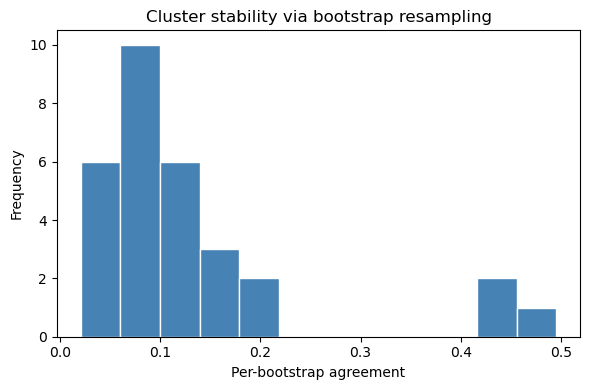

1     0.044525
2     0.106607
3     0.074091
4     0.056399
5     0.073302
6     0.057833
7     0.072475
8     0.055610
9     0.108874
10    0.105002
Name: clusterwise_stability, dtype: float64

In [ ]:
print("Running bootstrap resampling (this may take a few minutes)...")
boot_runs = bootstrap_cluster_labels(dist_matrix, k=k_reference, n_boot=30, sample_frac=0.75)

print("Computing stability scores (ARI)...")
stability_scores = compute_stability_scores(baseline_labels, boot_runs)

print(f"\nOverall Stability Metrics:")
print(f"  Mean ARI: {stability_scores.mean():.3f}")
print(f"  Std ARI: {stability_scores.std():.3f}")
print(f"  Min ARI: {stability_scores.min():.3f}")
print(f"  Max ARI: {stability_scores.max():.3f}")

plt.figure(figsize=(8, 5))
plt.hist(stability_scores, bins=12, color="steelblue", edgecolor="white", alpha=0.7)
plt.axvline(stability_scores.mean(), color="red", linestyle="--", label=f"Mean: {stability_scores.mean():.3f}")
plt.xlabel("Adjusted Rand Index (ARI)")
plt.ylabel("Frequency")
plt.title("Cluster stability via bootstrap resampling")
plt.tight_layout()
plt.show()

print("\nPer-cluster stability:")
clusterwise_scores = clusterwise_stability(baseline_labels, boot_runs, k_reference)
cluster_stability_df = pd.Series(clusterwise_scores, name="stability").sort_index()
print(cluster_stability_df)
